# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率
- 各ボートの2連率
- 各ボートの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- Logistic_regression_1よりは全体的にいい結果になるが、まだ実用化にたるものとは言えない。ギャンブル性がある。
- regressionに使う結果を、半年分入れるよりも、1ヶ月分など短期にする方が予測精度が上がる可能性がある
#### bet結果


In [1]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor
from datetime import datetime

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [2]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.main()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df[["exhibition_cource_1", "exhibition_ST_1"]])

/Users/grice/mywork/boatrace/src/analyze/../data_preparing/loader.py:357: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  race_results_supplementary_df = pd.concat(race_results_supplementary_df_list)


In [3]:
"""

# test用にdfを期間で区切って小さくして使いたい時
from_dt = datetime(2019, 1, 1)
to_dt = datetime(2019, 9, 1)

the_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]

"""

'\n\n# test用にdfを期間で区切って小さくして使いたい時\nfrom_dt = datetime(2019, 1, 1)\nto_dt = datetime(2019, 9, 1)\n\nthe_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]\n\n'

In [3]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # 特徴量のdfを作成
    fv_df = merged_df[fv_list]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_df.replace(key, value, inplace = True)

    # 会場名をbooleanに変換
    venue_df = pd.get_dummies(fv_df["venue"])
    
    # fv_dfの方の会場の列を削除
    fv_df = fv_df.drop("venue", axis=1)
    
    # 会場名がbooleanになったfv_dfの作成
    fv_df = pd.concat([fv_df, venue_df], axis=1)
    
    # なぜかdtypeがstrになっちゃうのでfloatに戻す
    fv_df = fv_df.astype(float)
    
    # labelのdfを作成
    label_df = merged_df[column_list_label]
    
    # ラベルをbooleanに変換
    label_df = analyzer_conf.make_label_boolean_ver1(label_df, column_list_label)
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """
    
    # オッズのdfを作成
    odds_df = merged_df[odds_list]
    
    # 解析用dfを作成
    fv_label_odds_df = pd.concat([fv_df, label_df, odds_df], axis=1)
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = pd.concat([fv_df, label_df], axis=1)
    # nanを含む行を削除
    fv_label_df = fv_label_df.dropna()
    
    """
    print(len(fv_df), len(label_df), len(odds_df))
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    print(fv_label_df)
    """
    
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []

# 開催地
fv_list.append("venue")    

for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各レーサーの該当枠における平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 各レーサーの該当枠における連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    
    # 勝率・二連率・三連率（全国）
    fv_list.append("win_rate_national_{0}".format(i))
    fv_list.append("place2Ratio_national_{0}".format(i))
    fv_list.append("place3Ratio_national_{0}".format(i))
    
    # 勝率・二連率・三連率（当地）
    fv_list.append("win_rate_local_{0}".format(i))
    fv_list.append("place2Ratio_local_{0}".format(i))
    fv_list.append("place3Ratio_local_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))
    
    # ボートの2連率、3連率
    fv_list.append("boat_place2Ratio_{0}".format(i))
    fv_list.append("boat_place3Ratio_{0}".format(i))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.8

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/grice/mywork/boatrace/src/analyze/analyzer_conf.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for_analysis_df.loc[for_analysis_df[column_name] != 1, column_name] = 0
/Users/grice/mywork/boatra

In [5]:
print(fv_label_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
96         0.0          18.0             853.0                 7.14   
97         2.0          16.0             545.0                 5.51   
98         1.0          13.0             880.0                 6.29   
99         2.0          18.0             273.0                 3.58   
100        0.0          15.0             923.0                 6.50   
101        2.0          14.0             417.0                 4.46   
102        1.0          15.0             682.0                 6.30   
103        0.0          16.0             840.0                 5.91   
104        0.0          13.0             885.0                 7.13   
105        0.0          14.0             848.0                 7.80   
36         0.0          15.0             739.0                 6.86   
37         2.0          19.0             538.0                 5.05   
38         2.0          35.0             250.0                 3.24   
39    

In [6]:
print(fv_label_odds_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
96         0.0          18.0             853.0                 7.14   
97         2.0          16.0             545.0                 5.51   
98         1.0          13.0             880.0                 6.29   
99         2.0          18.0             273.0                 3.58   
100        0.0          15.0             923.0                 6.50   
101        2.0          14.0             417.0                 4.46   
102        1.0          15.0             682.0                 6.30   
103        0.0          16.0             840.0                 5.91   
104        0.0          13.0             885.0                 7.13   
105        0.0          14.0             848.0                 7.80   
36         0.0          15.0             739.0                 6.86   
37         2.0          19.0             538.0                 5.05   
38         2.0          35.0             250.0                 3.24   
39    

1号艇についてtrainデータを使った正解率は0.6687775604257153,
           testデータを使った正解率は0.6536268399416523
2号艇についてtrainデータを使った正解率は0.6611849739730115,
           testデータを使った正解率は0.6381116562790081
3号艇についてtrainデータを使った正解率は0.6455687808759657,
           testデータを使った正解率は0.637581222649516
4号艇についてtrainデータを使った正解率は0.655250157488147,
           testデータを使った正解率は0.6444768598329134
5号艇についてtrainデータを使った正解率は0.6965617850867014,
           testデータを使った正解率は0.6805463466383769
6号艇についてtrainデータを使った正解率は0.7480521202877889,
           testデータを使った正解率は0.7424744728815806


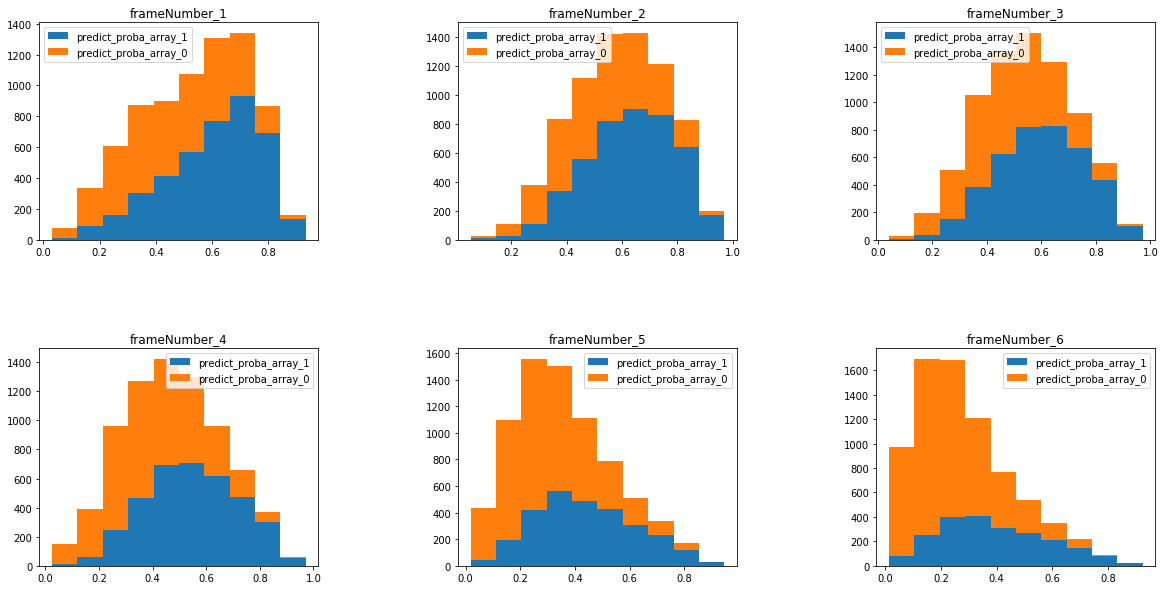

In [4]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))
    """
    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    # for j in range (coef.shape[1]):
        # print(fv_list[j], coef[0, j], "\n")
    """

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [5]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.841414    0.695322    0.417421    0.555589    0.319785    0.060589   
1       0.645422    0.469785    0.801702    0.613658    0.166171    0.085158   
2       0.774197    0.579218    0.764123    0.274711    0.030720    0.492538   
3       0.792416    0.878534    0.271118    0.397604    0.168047    0.178682   
4       0.290979    0.938827    0.234314    0.638706    0.127593    0.282667   
5       0.169874    0.861977    0.411213    0.452129    0.065189    0.758688   
6       0.477629    0.811803    0.331797    0.731231    0.308820    0.101229   
7       0.655554    0.567732    0.594379    0.658192    0.258601    0.101515   
8       0.495754    0.822968    0.481296    0.586369    0.116980    0.170319   
9       0.553352    0.617513    0.373732    0.290065    0.664012    0.171581   
10      0.620255    0.585461    0.474049    0.883482    0.198086    0.048524   
11      0.383795    0.596185    0.282722

In [8]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.7025576255131039, 回収率は0.9510893590148406
確率0.7以上で1に単勝betした場合、的中率は0.7497551420176298, 回収率は0.966258570029383
確率0.8以上で1に単勝betした場合、的中率は0.8233173076923077, 回収率は0.9691105769230769


In [7]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-59830, 回収率は0.8360821917808219
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-40350, 回収率は0.8233362521891419
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-15500, 回収率は0.8736756316218419
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は-8410, 回収率は0.8251559251559252
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-39110, 回収率は0.8428686219365207
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-28260, 回収率は0.8148099606815203
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-11970, 回収率は0.8524044389642417
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-4870, 回収率は0.8449044585987261
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-23280, 回収率は0.8362869198312236
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-16930, 回収率は0.8038238702201622
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-4690, 回収率は0.8941309255079006
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は-2030, 回収率は0.873125


In [6]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-717850, 回収率は0.7596269756228234
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-397130, 回収率は0.7585542315175098
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-137880, 回収率は0.7905832320777643
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-405530, 回収率は0.7780593257443082
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-207550, 回収率は0.7885594947025265
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-60190, 回収率は0.8435810810810811
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-137210, 回収率は0.8012601390498262
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-52360, 回収率は0.8522573363431152
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-540, 回収率は0.99578125


In [12]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-988410, 回収率は0.7765598155348585
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-688610, 回収率は0.7847286482430912
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-497030, 回収率は0.759563660990712
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-313090, 回収率は0.729628670120898
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-121830, 回収率は0.7407872340425532
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-704470, 回収率は0.7848026637341153
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-520740, 回収率は0.7784462219196733
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-352510, 回収率は0.7649933333333333
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-203040, 回収率は0.7519061583577713
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-73490, 回収率は0.7717701863354037
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-427510, 回収率は0.7912548828125
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-329810, 回収率は0.7731705639614855
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-244660, 回収率は0.7312609841827769
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-110670, 回収率は0.7741428571428571
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-48500, 回収率は0.7447368421052631
p1が0.8以上かつ、p2-6が0

In [13]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-173990, 回収率は0.8533462575859744
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-112540, 回収率は0.887953006770211
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-35520, 回収率は0.8862267777065983
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-100080, 回収率は0.8654115115653577
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-98580, 回収率は0.8520708283313325
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-24530, 回収率は0.8861188486536676
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-24090, 回収率は0.9162378303198887
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は-28560, 回収率は0.8979270907791279
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-12900, 回収率は0.8524027459954233


In [14]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("投票候補なし")

NameError: name 'termcolor' is not defined

In [10]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-217040, 回収率は0.8674160048869884
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-141550, 回収率は0.8756151142355009
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-80790, 回収率は0.890439381611066
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-36780, 回収率は0.9121776504297995
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-119220, 回収率は0.8604634831460675
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-65280, 回収率は0.8850704225352113
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-31100, 回収率は0.9121964991530209
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-10180, 回収率は0.9490490490490491
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-3080, 回収率は0.9654708520179373
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-39820, 回収率は0.87540675844806
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-8130, 回収率は0.9601470588235295
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-6130, 回収率は0.9476068376068376
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は7850, 回収率は1.1238170347003154
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は6300, 回収率は1.2386363636363635
p1が0.6以上かつ、p2

In [ ]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、2-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "2-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

In [9]:
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-217040, 回収率は0.8674160048869884
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-141550, 回収率は0.8756151142355009
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-80790, 回収率は0.890439381611066
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-36780, 回収率は0.9121776504297995
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-119220, 回収率は0.8604634831460675
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-65280, 回収率は0.8850704225352113
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-31100, 回収率は0.9121964991530209
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-10180, 回収率は0.9490490490490491
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-3080, 回収率は0.9654708520179373
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-39820, 回収率は0.87540675844806
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-8130, 回収率は0.9601470588235295
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-6130, 回収率は0.9476068376068376
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は7850, 回収率は1.1238170347003154
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は6300, 回収率は1.2386363636363635
p1が0.6以上かつ、p2

In [ ]:
# 1号艇の勝率x_1以上,3号艇の勝率x_2以上のとき、3-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_3".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "3-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

In [ ]:
# 1号艇の勝率x_1以上,4号艇の勝率x_2以上のとき、4-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_4".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "4-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

In [ ]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、1-2にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "1-2":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

In [ ]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のときで、x_3を超えている他の艇に対して2-1-XXにbet
x_1_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.2, 0.3, 0.4, 0.5, 0.6]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    if row["PredProb_2".format(j)] > x_2:
                        for i in range(3, 7):
                            if row["PredProb_{0}".format(i)] > x_3:
                                bet = bet + 100

                                if row["trifecta"] == "2-1-{0}".format(i):
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1 > {0}、p2 > {1}, p3 > {2}で3連単2-1-i にbetすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income / bet) < 1:
                    text = termcolor.colored(text, "red")
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

### マーチンゲール法

- 結構固めの基準（0.7, 0.7, 0.7）とかでやっても掛け金が70万くらいいっちゃう
- 3連単はえぐいので、やるとしたら2連単1頭2つまで、2回連続外れで倍とかくらいかなあ

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-1600, 回収率は0.0


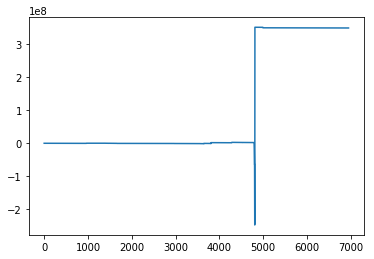

p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-1600, 回収率は0.0


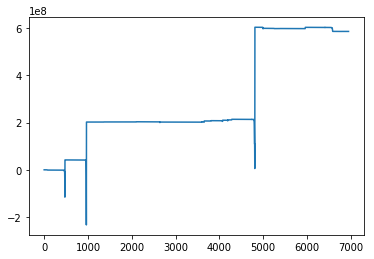

p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-200, 回収率は0.0


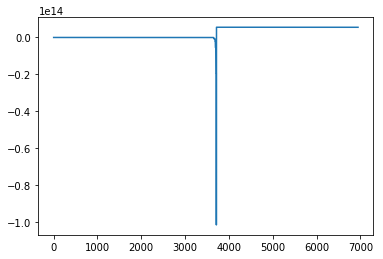

p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-200, 回収率は0.0


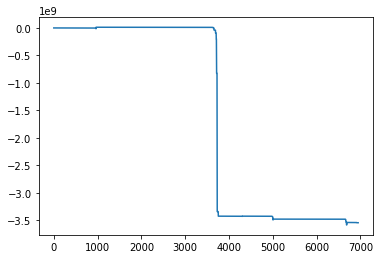

p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-800, 回収率は0.0


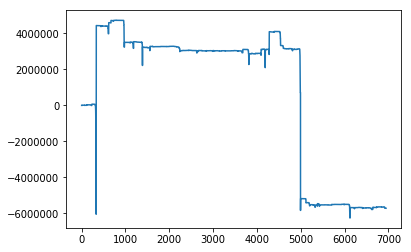

p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-800, 回収率は0.0


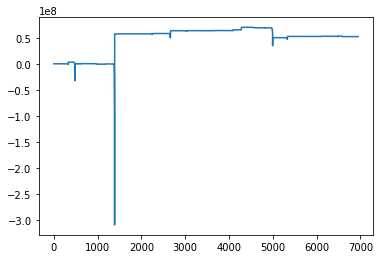

p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-200, 回収率は0.0


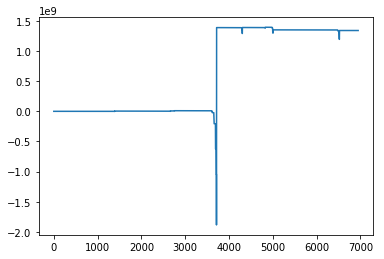

p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-200, 回収率は0.0


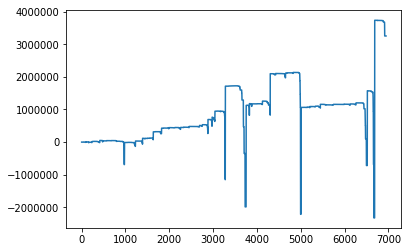

p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-200, 回収率は0.0


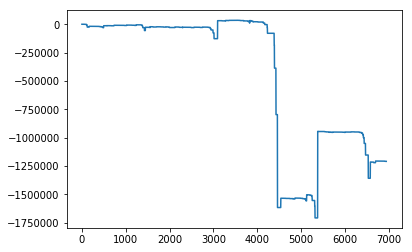

p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-100, 回収率は0.0


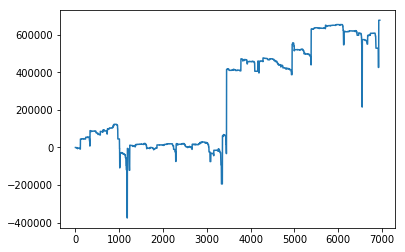

p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-100, 回収率は0.0


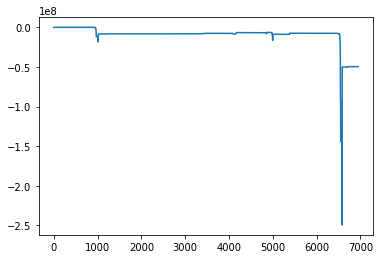

p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-100, 回収率は0.0


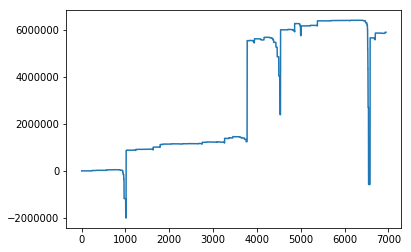

p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-800, 回収率は0.0


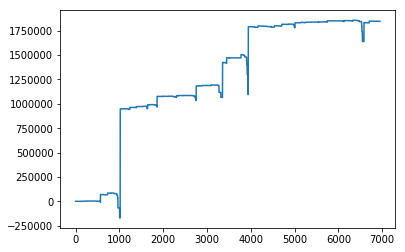

p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-200, 回収率は0.0


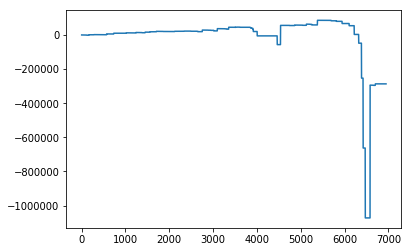

p1が0.6以上かつ、p2が0.8以上かつp3が0.8で3連単betすると収益は-100, 回収率は0.0


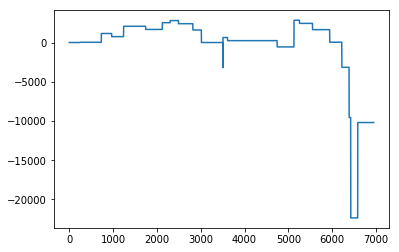

p1が0.7以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-800, 回収率は0.0


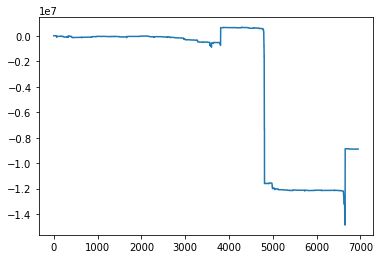

p1が0.7以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-800, 回収率は0.0


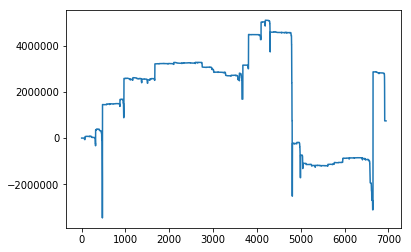

p1が0.7以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-400, 回収率は0.0


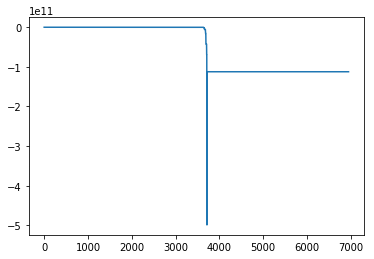

p1が0.7以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-200, 回収率は0.0


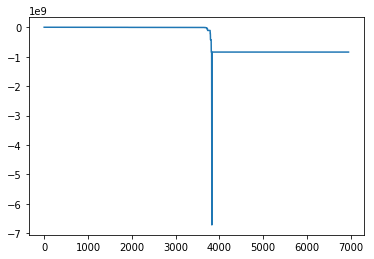

p1が0.7以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-400, 回収率は0.0


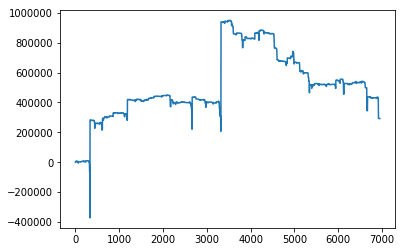

p1が0.7以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-400, 回収率は0.0


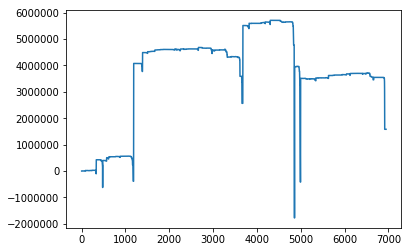

p1が0.7以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-400, 回収率は0.0


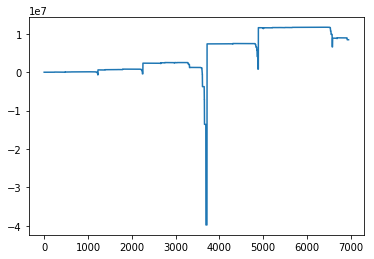

p1が0.7以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-200, 回収率は0.0


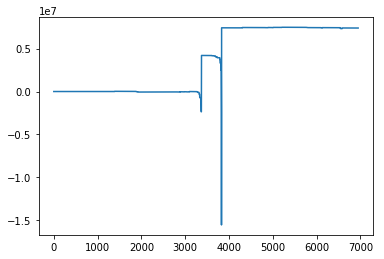

p1が0.7以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-200, 回収率は0.0


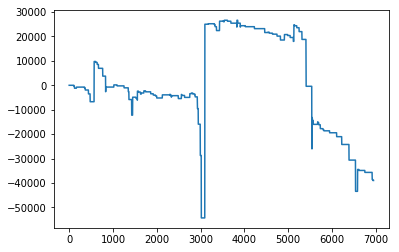

p1が0.7以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-100, 回収率は0.0


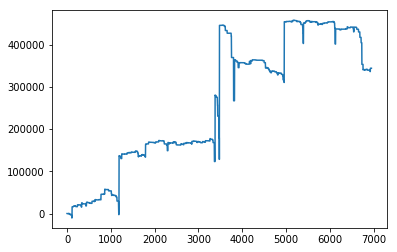

p1が0.7以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-100, 回収率は0.0


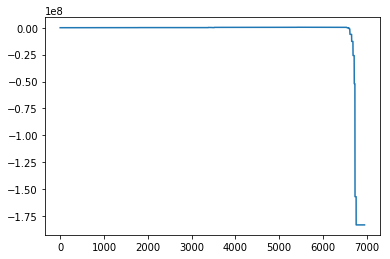

p1が0.7以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-100, 回収率は0.0


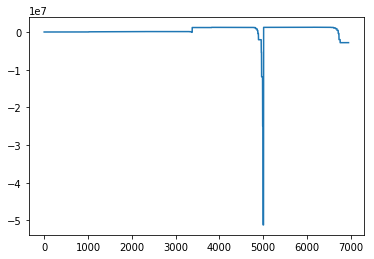

p1が0.7以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-100, 回収率は0.0


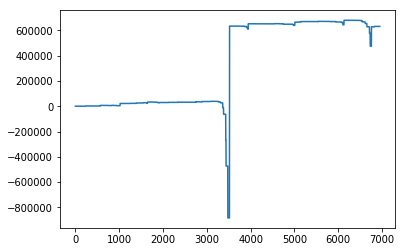

p1が0.7以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-51200, 回収率は0.0


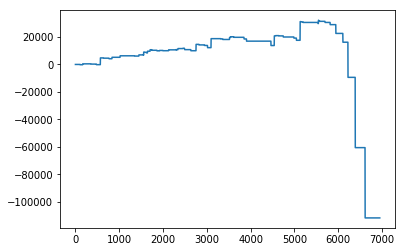

p1が0.7以上かつ、p2が0.8以上かつp3が0.8で3連単betすると収益は-1600, 回収率は0.0


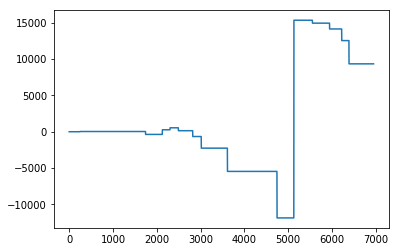

p1が0.75以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-200, 回収率は0.0


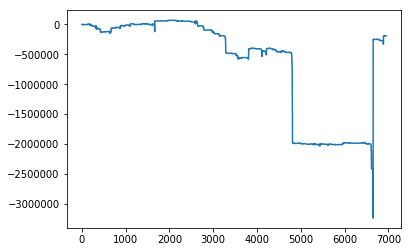

p1が0.75以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-200, 回収率は0.0


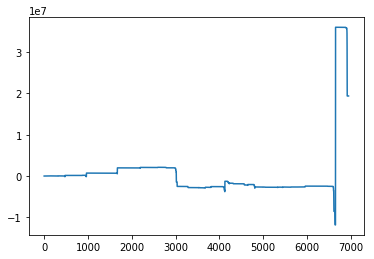

p1が0.75以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-200, 回収率は0.0


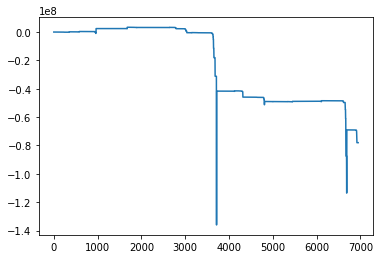

p1が0.75以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-200, 回収率は0.0


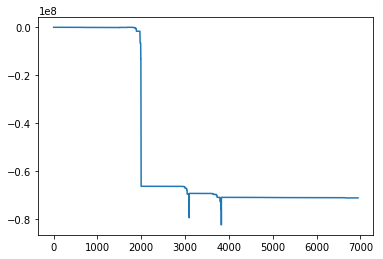

p1が0.75以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-200, 回収率は0.0


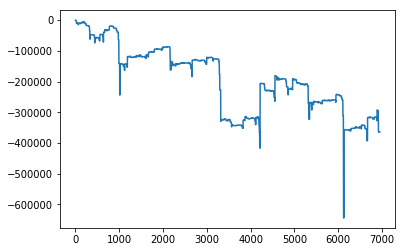

p1が0.75以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-200, 回収率は0.0


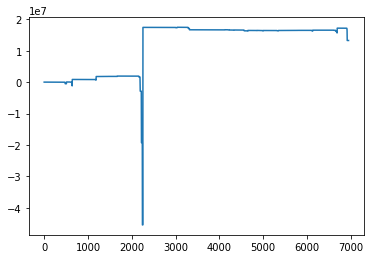

p1が0.75以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-200, 回収率は0.0


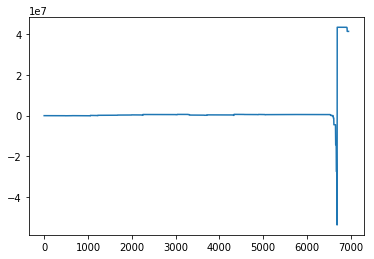

p1が0.75以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-200, 回収率は0.0


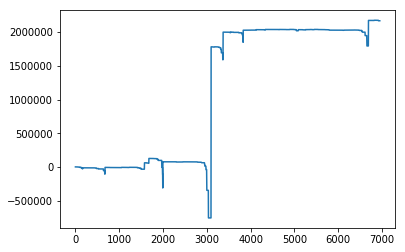

p1が0.75以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-200, 回収率は0.0


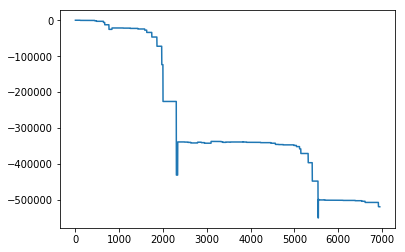

p1が0.75以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-100, 回収率は0.0


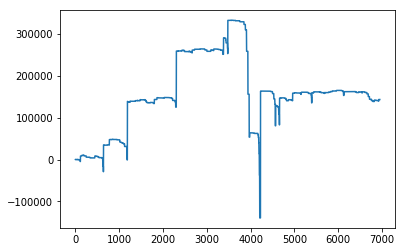

p1が0.75以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-100, 回収率は0.0


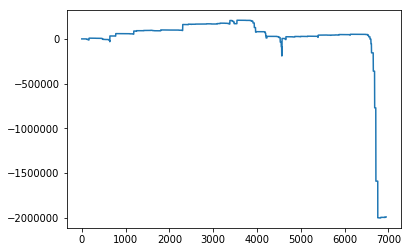

p1が0.75以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-100, 回収率は0.0


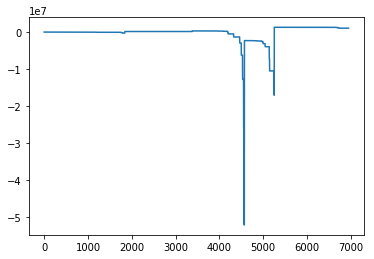

p1が0.75以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-100, 回収率は0.0


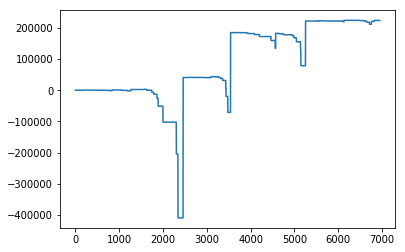

p1が0.75以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-3200, 回収率は0.0


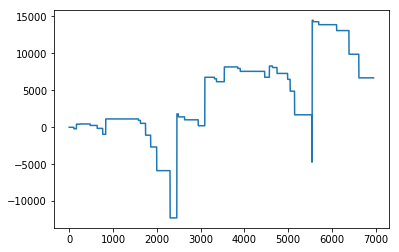

p1が0.75以上かつ、p2が0.8以上かつp3が0.8で3連単betすると収益は-1600, 回収率は0.0


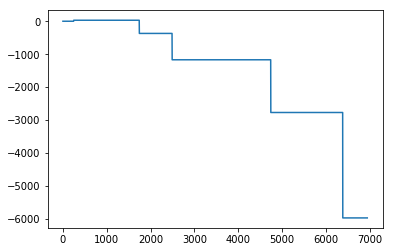

p1が0.8以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-200, 回収率は0.0


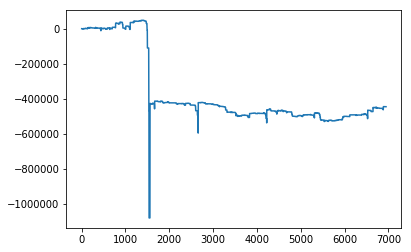

p1が0.8以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-12800, 回収率は0.0


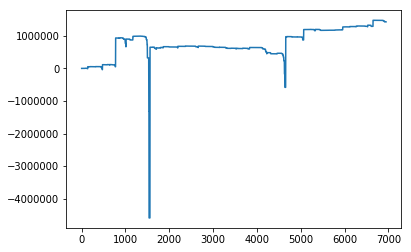

p1が0.8以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-51200, 回収率は0.0


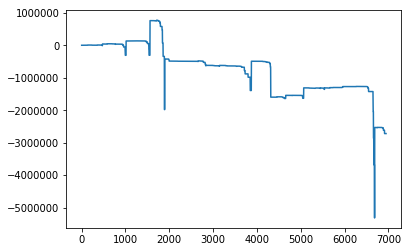

p1が0.8以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-3200, 回収率は0.0


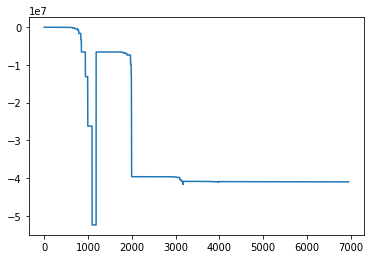

p1が0.8以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-400, 回収率は0.0


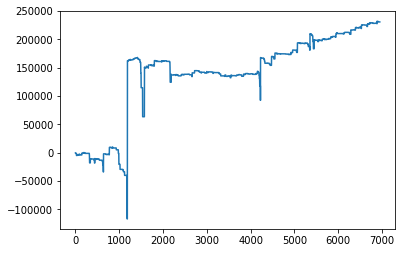

p1が0.8以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-3200, 回収率は0.0


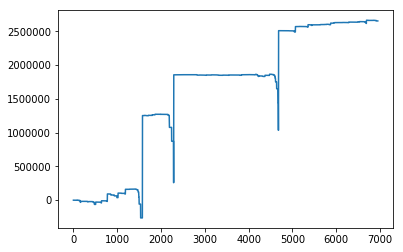

p1が0.8以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-12800, 回収率は0.0


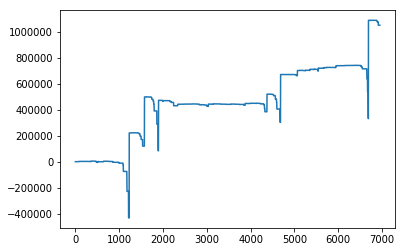

p1が0.8以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-1600, 回収率は0.0


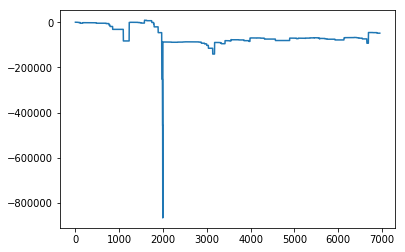

p1が0.8以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-800, 回収率は0.0


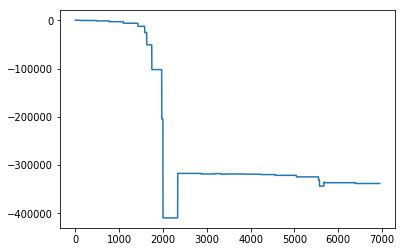

p1が0.8以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-800, 回収率は0.0


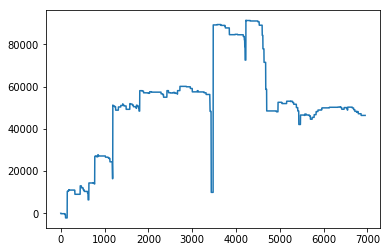

p1が0.8以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-800, 回収率は0.0


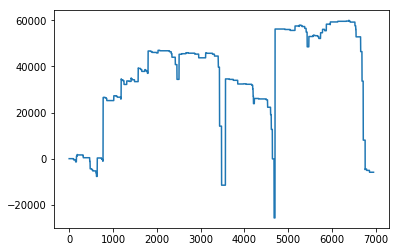

p1が0.8以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-800, 回収率は0.0


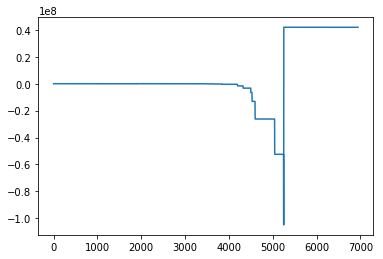

p1が0.8以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-400, 回収率は0.0


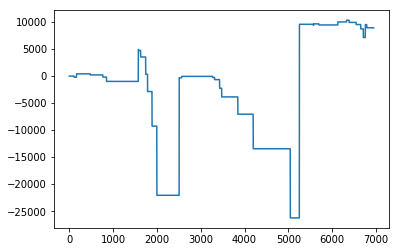

p1が0.8以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-409600, 回収率は0.0


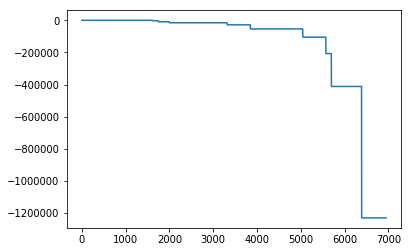

p1が0.8以上かつ、p2が0.8以上かつp3が0.8で3連単betすると収益は-400, 回収率は0.0


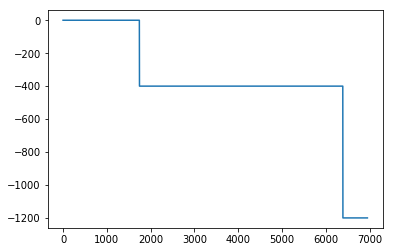

In [43]:
np.set_printoptions(threshold=np.inf)

x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income_list = []
                bet_list = []
                profit_list = []
                
                for index, row in for_calc_refund_rate_df.iterrows():
                    # betを決定
                    if index == 0:
                        bet = 100
                    elif income_list[-1] != 0:   # 的中後は0に戻す
                        bet = 100
                    elif len(bet_number_list) == 0:   # 投票候補がない場合
                        bet = bet
                    else:
                        bet = 2 * bet   # 外した場合
                    
                    # betする組番のリスト（1-2-3とか）
                    bet_number_list = []
                    
                    # 賭ける組番をかき出し
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet_number_list.append("1-{0}-{1}".format(j, k))
                                        bet_number_list.append("1-{0}-{1}".format(k, j))
                    
                    # 今回のbetによる当たり額を算出（betなしの時も0とする）
                    if row["trifecta"] in bet_number_list:
                        income = row["trifectaOdds"] * bet / 100
                    else:
                        income = 0
                    
                    bet_list.append(bet * len(bet_number_list))
                    income_list.append(income)
                    
                    # 本レースの利益
                    profit = income - bet * len(bet_number_list)
                    if index == 0:
                        pass
                    else:
                        profit = profit_list[-1] + profit
                    profit_list.append(profit)

                    # print("bet = {0} * {1}, income = {2}, cum_profit = {3}".format(bet, len(bet_number_list), income, profit))
                
                # 結果をかき出し
                try:
                    print("p1={0}, p2={1}, p3={2}".format(x_1, x_2, x_3))
                    plt.plot(np.array(profit_list))
                    plt.show()
                    
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))